# Linear Regression Project

## Introduction

This project requires us to build a linear model that predicts the number of crew members needed to man a cruise liner, based on specific features of the cruise ship. The objective the model is predictive accuracy, so the model will primarily be evaluated on it's ability to predict accurately for unseen data.

The data set provided contains the following variables:

* Ship Name
* Cruise Line
* Age (as of 2013)
* Tonnage (in the 1000s)
* Passenger limit (in the 100s)
* Length (in the 100s of ft)
* Cabins (in the 100s)
* Passenger Density
* Crew (in the 100s)

<br>

---

<br>

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

SEED = 42
DATA_PATH = "../course_materials/Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv"

# initialize spark session
spark = SparkSession.builder.appName("Linear Regression Project").getOrCreate()

# load data
df = spark.read.csv(DATA_PATH, inferSchema = True, header = True)

<br>

---

<br>

## EDA

### Ship Name

In [2]:
print("Number of Rows: " + str(df.count()))

df.printSchema()

df.show()

Number of Rows: 158
root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11| 

In [3]:
df.select( F.countDistinct(df["Ship_name"]).alias("Distinct Ship Names") ).show()

+-------------------+
|Distinct Ship Names|
+-------------------+
|                138|
+-------------------+



There are only 138 distinct ship names despite having 158 rows; this implies that some ship names are repeated.

In [4]:
df.groupBy("Ship_name").agg(F.count("Ship_name").alias("count")).filter( "count > 1" ).show()

+---------+-----+
|Ship_name|count|
+---------+-----+
|     Wind|    2|
|  Majesty|    2|
|   Spirit|    4|
|     Dawn|    2|
|      Sun|    2|
|Navigator|    2|
|    Pride|    2|
|      Sea|    2|
| Rhapsody|    2|
|  Mariner|    2|
|  Freedom|    2|
|    Crown|    2|
|   Legend|    3|
|     Star|    3|
|    Jewel|    2|
|  Voyager|    2|
+---------+-----+



In [5]:
df.filter( "Ship_name = 'Spirit'").show()

+---------+-----------+---+-----------------+----------+------+------+-----------------+-----+
|Ship_name|Cruise_line|Age|          Tonnage|passengers|length|cabins|passenger_density| crew|
+---------+-----------+---+-----------------+----------+------+------+-----------------+-----+
|   Spirit|   Carnival| 12|             88.5|     21.24|  9.63| 10.56|            41.67|10.29|
|   Spirit|  Norwegian| 15|75.33800000000001|     19.56|  8.79|  9.83|            38.52| 13.0|
|   Spirit|   Seabourn| 24|             10.0|      2.08|   4.4|  1.04|            48.08|  1.6|
|   Spirit|   Windstar| 25|             5.35|      1.58|   4.4|  0.74|            33.86| 0.88|
+---------+-----------+---+-----------------+----------+------+------+-----------------+-----+



The name "Spirit" occurs 4 times, each operated by a different cruise line. It's likely that the `Ship_name` and `Cruise_line` combine to uniquely identify each row in the data set. We can check this with a group by + count.

In [6]:
df.groupBy(["Ship_name", "Cruise_line"]).agg(F.count("Ship_name").alias("count")).filter( "count > 1" ).show()

+---------+-----------+-----+
|Ship_name|Cruise_line|count|
+---------+-----------+-----+
+---------+-----------+-----+



We see that no combination of `Ship_name` x `Cruise_line` occurs more than once.

## Cruise Line

In [7]:
df.groupBy("Cruise_line").agg(
    F.count("Ship_name").alias("ships"), 
    F.mean("age").alias("mean_age"),
    F.mean("tonnage").alias("mean_tonnage"),
    F.mean("passengers").alias("mean_passengers"),
    F.mean("length").alias("mean_length"),
    F.mean("cabins").alias("mean_cabins"),
    F.mean("passenger_density").alias("mean_passenger_dens"),
    F.mean("crew").alias("mean_crew")
).show()

+-----------------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|      Cruise_line|ships|          mean_age|      mean_tonnage|   mean_passengers|       mean_length|       mean_cabins|mean_passenger_dens|         mean_crew|
+-----------------+-----+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|            Costa|   11|16.181818181818183| 71.09654545454545|19.200000000000003| 8.138181818181819| 9.257272727272728|  37.31181818181819|               7.7|
|              P&O|    6|              14.0| 77.85883333333334|20.820000000000004|              8.64| 9.790000000000001| 38.175000000000004| 8.588333333333333|
|           Cunard|    3|              20.0|103.90899999999999|             21.37|10.196666666666667|10.376666666666667|  47.35333333333333|10.246666666666668|
|Regent_Seven_Seas|    5|              1

There are 20 different cruise lines in the data set.

* Royal Carribbean and Carnival are the most prominent with cruise lines with 20+ ships each. Princess comes in 3rd with 17 ships with Holland American and Norwegian rounding out the top 5 cruise liners with the most ships. These 5 cruise lines account for 89 of the 158 ships in the data set (approx. 56%).

* Amongst the top 5 cruise lines, Norwegian and Holland American generally have the oldest ships at an average of 17 years old. Princess generally has the newest ships at an average of 13 years old.

* Royal Carribbean has the highest average passenger capacity at ~2,885 passengers. Seabourn generally has some of oldest ships while also having the lowest passenger capacity at about 208 passengers. This isn't surprising since Royal Carribbean also boasts the highest average tonnage at 107,000 tons. What is surprising is Carnival has a higher average passenger capacity than Princess and Cunard, despite having a lower average tonnage per ship.

* Cruise ship lengths are roughly comparable across the top 5 cruise lines ranging from 7,800 ft to 9,600 ft. Royal Carribbean again takes the top spot with the longest ships on average.

* Unsurprisingly, Royal Carribbean also has the highest average cabin count at ~1,300 cabins. This makes sense since Royal Carribbean has the highest average passenger capacity, so they would require more cabins to accommodate passengers. By similar logic, it is unsurprising that Seabourn (having the lowest average passenger capacity) would also have the lowest average cabin count at ~100.

* Royal Carribbean ships boast the largest ships on average, but surprisingly are slightly behind Cunard and Carnival in average crew count. Cunard does have an average tonnage that rivals Royal Carribbean. What is surprising is that Carnival ships have noticeably less tonnage than both Royal and Cunard, while having a lower average passenger capacity than Royal Carribean. Yet Carnival ranks second in average crew count per ship. This might be due to Carnival having unique staffing mixes.

<Axes: >

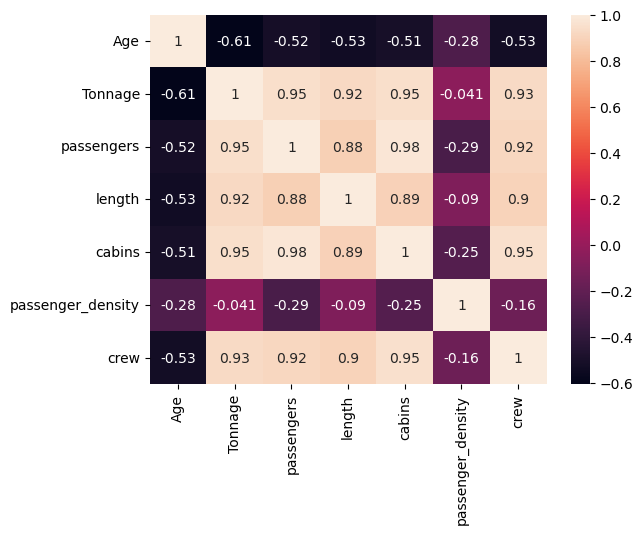

In [8]:
# look at the correlation matrix of the numeric columns
numeric_cols = [
    "Age",
    "Tonnage",
    "passengers",
    "length",
    "cabins",
    "passenger_density",
    "crew"
]

numeric_assembler = VectorAssembler(
    inputCols = numeric_cols,
    outputCol = "features"
)

# use the Correlation object pyspark to get the correlation matrix;
# note that the corr() method requires us to assemble all the 
# numeric columns into a single vector
cor_mat = Correlation.corr(numeric_assembler.transform(df).select("features"), column = "features", method = "pearson")

# the correlation matrix is stored as a single entry
# in a 1x1 dataframe, which we need to extract
cor_mat = cor_mat.collect()[0]["pearson(features)"]

# coerce into a pandas dataframe for visualization
cor_mat = cor_mat.toArray().tolist()

cor_mat = pd.DataFrame(cor_mat, columns = numeric_cols, index = numeric_cols)

sns.heatmap(cor_mat, annot = True)

The correlation matrix gives us a preliminary idea about how the different variables are related to each other.

* Unsurprisingly, `Tonnage`, `passengers`, `legnth`, and `cabins` are all highly correlated with each other. This makes sense larger ships are needed for more cabins to fit more passengers.
  
* `Age` is negatively correlated with `Tonnage`, `passengers`, `length`, and `cabins`. This makes sense new technology generally makes it easier to build larger cruise ships.

* `crew` is positively correlated with `Tonnage`, `passengers`, `length` and `cabins`; this make sense since larger ships and more passengers will naturally require more crew members to manage and service. `crew` is negatively correlated with `Age`, which also makes sense since newer ships generally tend to be larger (as demonstrated by the negative correlation between `Age` and size).

* `passenger_density` doesn't really exhibit strong correlations with any variable in particular. This likely because `passenger_density` is a normalized value.

Generally speaking, size of the ship is most correlated with crew count. The 4 variables `Tonnage`, `passengers`, `length`, and `cabins` are highly collinear with each other, indicating that these variables are all measuring the same latent concept of "size". If we wish to have "simple" model, we probably wouldn't lose too much information by dropping 1 or 2 of these variables. 

Another thing to note is that Carnival had a higher average crew count than Royal Caribbean despite having noticeable smaller ships on average. This is likely due to intrinsic differences in how Carnival ships are staffed vs Royal Caribbean (and other cruise lines). In particular, we might want to add a dummy variable for each cruise line to control for the "between cruise line" staffing variations. However, this might not be feasible since some cruise lines only have 1 ship (i.e. Orient). In light of this, we will start by including a single dummy variable to indicate whether a ship belongs to Carnival.

<br>

---

<br>

## The Model

In [9]:
# add an indicator for Carnival ships
df_model = df.withColumns(
    {
        "is_carnival" : F.when(df["Cruise_line"] == "Carnival", 1).otherwise(0)
    }
)

inputCols = [
    "Age",
    "Tonnage",
    "passengers",
    "length",
    "cabins",
    "is_carnival"
]
    

# assemble features into vector
assembler = VectorAssembler(
    inputCols = inputCols,
    outputCol = "features"
)

df_model = assembler.transform(df_model)

df_model.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|is_carnival|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|          0|[6.0,30.276999999...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|          0|[6.0,30.276999999...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|          1|[26.0,47.262,14.8...|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|          1|[11.0,110.0,29.74...|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36

In [10]:
# train-test split
df_train, df_test = df_model.randomSplit([0.7, 0.3], seed = SEED)

print(f"Training Data Size: {df_train.count()}")
print(f"Testing Data Size: {df_test.count()}")

Training Data Size: 110
Testing Data Size: 48


In [31]:
# fit inital model
lr_estimator = LinearRegression(
    featuresCol = "features",
    labelCol = "crew",
    predictionCol = "prediction"
)

lr_model = lr_estimator.fit(df_train)

lr_summary = lr_model.summary

lr_model.coefficients

DenseVector([-0.0133, 0.0203, -0.1508, 0.4353, 0.7207, 0.2934])

Note that the `passenger` coefficient is estimated to be -0.15 which doesn't make real-world sense and is likely due to the heavy multicollinearity between `passenger` and the other predictors. For the purposes of prediction, this isn't an issue since we don't actually need to justify why the coefficient should be negative as long as the model to predicts accurately.

In [12]:
# view errors on training set
print(f"R2: {lr_summary.r2}")
print(f"Adjusted R2: {lr_summary.r2adj}")
print(f"Train MSE: {lr_summary.meanSquaredError}")
print(f"Train RMSE: {lr_summary.rootMeanSquaredError}")
print(f"Train MAE: {lr_summary.meanAbsoluteError}")

R2: 0.9545365084415813
Adjusted R2: 0.951888149710023
Train MSE: 0.511023712497815
Train RMSE: 0.7148592256506276
Train MAE: 0.5469193519168523


In [13]:
# view results on test set
test_results = lr_model.evaluate(df_test)

print(f"Test MSE: {test_results.meanSquaredError}")
print(f"Test RMSE: {test_results.rootMeanSquaredError}")
print(f"Test MAE: {test_results.meanAbsoluteError}")

Test MSE: 1.809477141277445
Test RMSE: 1.345168071758115
Test MAE: 0.7244788096966848


The model has an adjusted $R^2$ of about 0.95, so ~95% of the variance in `crew` (in the training data set) is explained by the model using just 6 variables (this is very good!). However, the mean squared error is more than 3x on the testing data set than the training data set, which indicates the model might be overfitting. However, it's also possible that the high test error is due to random chance; the test data only contains 45 data points after all. We could properly investigate this by doing cross validation (either k-fold or leave-one-out), which requires a bit of code to get up and running. An easier proxy is to bootstrap the test MSE by changing the random seed of `randomSplit()` $n$-many times to generate $n$ different versions of train-test splits. We can then fit the model on the training set and evaluate on the testing set $n$-many times; averaging out the train and test MSE's would give us a "bootstrapped" MSE.

In [49]:
train_mse_list = []
test_mse_list = []

for i in range(50):
    
    df_train, df_test = df_model.randomSplit([0.7, 0.3], seed = i)
    lr_estimator = LinearRegression(
        featuresCol = "features",
        labelCol = "crew",
        predictionCol = "prediction"
    )
    
    lr_model = lr_estimator.fit(df_train)
    train_mse = lr_model.summary.meanSquaredError
    test_mse = lr_model.evaluate(df_test).meanSquaredError

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

In [50]:
print(f"Avg Train MSE: {sum(train_mse_list)/len(train_mse_list)}")
print(f"Avg Test MSE: {sum(test_mse_list)/len(test_mse_list)}")

Avg Train MSE: 0.9008720183279756
Avg Test MSE: 0.9182269159669307


Using a bootstrap sample of size 50, the estimated Train and Test MSE values are pretty close, indicating that the model isn't likely to be overfit.

Despite the results of the bootstrap, let's see what would happen if we assumed the model was overfitting. In this case, there would be 2 options:

1) Drop some variables to reduce the model complexity. For example, it's likely that `passenger` and `cabin` both measure the same thing and having both variables isn't likely to give us any new information that isn't just random noise. We can automate the variable selection process using a number of techniques, but the easiest one to use would be LASSO aka L1-penalty.

2) Limit the range of possible models by restricting the size of the coefficients. For example, since `passenger` and `cabin` likely measure the same thing, it would make sense to keep their coefficients at roughly the same magnitude. The the most common way to restrict coefficient size is to use Ridge aka L2-penalty.

LASSO, Ridge, and their hybrid child ElasticNet both come pre-buil with the `LinearRegression` estimator; we just need to pass in the following arguments:

* `regParam` stipulates the size of the penalty term. Larger values will lead to stronger regularization and will more aggressively reduce overfitting (at the cost of increasing underfitting). The optimal `regParam` is usually found by hyperparameter tuning via cross-validation.

* `elasticNetParam` gives the weighting of the L1 vs L2-penalty terms. A value of 0 will use all L2-penalty (resulting in Ridge), while a value of 1 will use all L1-penalty (resulting in LASSO). An **ElasticNet** model is any model where the value is strictly between 0 and 1, i.e. the model uses a weighted average of L1 and L2 penalty terms.

## LASSO

In [25]:
# fit inital model
lasso_estimator = LinearRegression(
    featuresCol = "features",
    labelCol = "crew",
    predictionCol = "prediction",
    regParam = 0.1,  # size of the penalty term; usually chosen via cross-validation
    elasticNetParam = 1, # L1 vs L2 weighting; 0 = ridge vs 1 = LASSO
)

lasso_model = lasso_estimator.fit(df_train)

lasso_summary = lasso_model.summary

In [26]:
lasso_model.coefficients

DenseVector([-0.0045, 0.0121, 0.0, 0.4082, 0.4663, 0.0403])

This LASSO model with a penalty weight of 0.1 set the `passengers` coefficient to 0.

In [27]:
# view errors on training set
print(f"R2: {lasso_summary.r2}")
print(f"Adjusted R2: {lasso_summary.r2adj}")
print(f"Train MSE: {lasso_summary.meanSquaredError}")
print(f"Train RMSE: {lasso_summary.rootMeanSquaredError}")
print(f"Train MAE: {lasso_summary.meanAbsoluteError}")

print("\n-------------------\n")
# view results on test set
test_results = lasso_model.evaluate(df_test)

print(f"Test MSE: {test_results.meanSquaredError}")
print(f"Test RMSE: {test_results.rootMeanSquaredError}")
print(f"Test MAE: {test_results.meanAbsoluteError}")

R2: 0.9435168240274504
Adjusted R2: 0.9402265419319621
Train MSE: 0.6348883750397912
Train RMSE: 0.7967988297178851
Train MAE: 0.6067190978258384

-------------------

Test MSE: 1.9454422910670879
Test RMSE: 1.3947911281145604
Test MAE: 0.7533282831162338


Adding regularization actually causes testing error to go up, which might indicate that the model is actually underfit (and that the original test MSE of 1.8 was a freak outlier).

## Ridge

In [35]:
# fit inital model
ridge_estimator = LinearRegression(
    featuresCol = "features",
    labelCol = "crew",
    predictionCol = "prediction",
    regParam = 0.1,  # size of the penalty term; usually chosen via cross-validation
    elasticNetParam = 0, # L1 vs L2 weighting; 0 = ridge vs 1 = LASSO
)

ridge_model = ridge_estimator.fit(df_train)

ridge_summary = ridge_model.summary

In [36]:
ridge_model.coefficients

DenseVector([-0.0127, 0.0218, -0.0286, 0.4389, 0.436, 0.4135])

In [37]:
# view errors on training set
print(f"R2: {ridge_summary.r2}")
print(f"Adjusted R2: {ridge_summary.r2adj}")
print(f"Train MSE: {ridge_summary.meanSquaredError}")
print(f"Train RMSE: {ridge_summary.rootMeanSquaredError}")
print(f"Train MAE: {ridge_summary.meanAbsoluteError}")

print("\n-------------------\n")
# view results on test set
test_results = ridge_model.evaluate(df_test)

print(f"Test MSE: {test_results.meanSquaredError}")
print(f"Test RMSE: {test_results.rootMeanSquaredError}")
print(f"Test MAE: {test_results.meanAbsoluteError}")

R2: 0.9474609276881933
Adjusted R2: 0.9444003992040104
Train MSE: 0.5905554295026183
Train RMSE: 0.7684760435450271
Train MAE: 0.5714335156307594

-------------------

Test MSE: 1.866300247326232
Test RMSE: 1.3661259997987858
Test MAE: 0.7360747209190911


Again, adding regularization causes test MSE to go up, so it's unlikely that the model is that severely overfit.

<br>

---

<br>